<a href="https://colab.research.google.com/github/NN198/LLM-Magic/blob/main/Dissertation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages for training

In [ ]:
pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.3 MB/s eta 0:00:00


# Packages for training

In [ ]:
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install accelerate transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
     

##**Model/Libraries**

In [ ]:
from datasets import Dataset,load_dataset
import pandas as pd
import torch
import os
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import openai
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback
import requests
import json
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer

**Importing the HC3 dataset using the Model card** &nbsp;

Available corpus - https://huggingface.co/datasets/Hello-SimpleAI/HC3

In [ ]:
dataset = load_dataset('Hello-SimpleAI/HC3', "all", split='train')

df = pd.DataFrame(dataset)

def sample_and_shuffle(df, source_list, n=400):
    df_sampled = df[df['source'].isin(source_list)].groupby('source').apply(lambda x: x.sample(n=n, random_state=1)).reset_index(drop=True)
    df_shuffled = df_sampled.sample(frac=1, random_state=1).reset_index(drop=True)
    return df_shuffled

sources = ['finance', 'medicine', 'open_qa', 'reddit_eli5', 'wiki_csai']

df_prepared = sample_and_shuffle(df, sources)
df_prepared.to_csv('hc3_dataset.csv', index=False)

print("Dataset prepared and saved as 'hc3_dataset.csv'.")


Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

Dataset prepared and saved as 'hc3_dataset.csv'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to get paraphrased text from the API
def get_paraphrased_text(answer):
    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
    prompt = f"Enhance the word choices to sound like human in around 300 tokens for the sentence without typing anything before and after the main prompt: {answer}"
    payload = {
        "model": "llama3.1",
        "prompt": prompt,
        "stream": False  # Assuming streaming is not required here
    }
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    if response.status_code == 200:
        paraphrased_text = response.json().get('response', '')
        return paraphrased_text
    else:
        return "Error in paraphrasing"

# Add a new column for paraphrased text, updating the DataFrame as responses are generated
paraphrased_responses = []
for idx, row in train_df.iterrows():  # Start from row 64
    paraphrased_text = get_paraphrased_text(row['answer'])
    paraphrased_responses.append(paraphrased_text)
    print(paraphrased_text)
    print(f"Paraphrasing for row {idx} completed.")

# Ensure the correct length for alignment with original DataFrame
train_df['paraphrased_responses']= paraphrased_responses

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
import pandas as pd
import requests
import json

raw_texts = df_radar['paraphrased2_llama'].tolist()


def openai_response(text, top_k, temperature, top_p, frequency_penalty):
    url = "http://localhost:11434/api/generate"
    headers = {"Content-Type": "application/json"}
    prompt = f"Paraphrase and Enhance the word choices of '{text}' to sound like human for the sentence without typing anything before and after the main prompt."
    payload = {
        "model": "llama3.1",
        "prompt": prompt,
        "stream": False,  # Assuming streaming is not required here
        "options": {
            "temperature": temperature,
            "frequency_penalty": frequency_penalty,
            "top_p": top_p,
        }
    }
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    if response.status_code == 200:
        paraphrased_text = response.json().get('response', '')
        print(paraphrased_text)
        return paraphrased_text
    else:
        return "Error in paraphrasing"


# Generate further enhanced paraphrases
# Paraphrased_responses = [ParaphraseNLG.openai_response(text,top_k=20, temperature=1, top_p=0.1, frequency_penalty=1.7) for text in raw_texts]
paraphrased_responses = []
for idx, row in df_radar.iterrows():  # Start from row 64
    paraphrased_text = openai_response(row['paraphrased2_llama'],top_k=20, temperature=1.5, top_p=0.1, frequency_penalty=1.7)
    paraphrased_responses.append(paraphrased_text)
    print(paraphrased_text)
    print(f"Paraphrasing for row {idx} completed.")

# https://tarpon-fresh-suitably.ngrok-free.app/llm/service/api/chat
df_radar['paraphrased31_llama'] = paraphrased_responses
df_radar.to_csv('/content/drive/My Drive/Colab Notebooks/dataset/radar1003_dataset.csv')

Streaming output truncated to the last 5000 lines.

In terms of ventricles and basilar cisterns - crucial fluid-filled spaces within the brain that enable its proper functioning, they're described as being normal-sized.

Overall, your MRI report suggests there's been some tissue damage or swelling present but no signs of an acute stroke. It's essential to note this interpretation is based solely on the information provided and a comprehensive evaluation would require further review by a healthcare professional.
Paraphrasing for row 618 completed.
Here's a paraphrased and enhanced version of the text:

For centuries, rustic gristmills have stood as steadfast sentinels in rural landscapes, their unobtrusive yet indispensable presence quietly transforming bread-making traditions with each passing day. This venerable water-powered workhorse - affectionately known to many as a flour mill or simply "the heart" of local bakeries - has been faithfully serving its purpose since ancient times.



# Data generation using ICL

In [ ]:
import pandas as pd
import requests
import json

# Function to get paraphrased text from the API and iterate through user-assistant roles for 3 cycles
def get_paraphrased_text(question, answer, gpt4om, cycles=3):
    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
    initial_prompt = f"Paraphrase the following text to enhance its language and make it sound more natural and human-like, while retaining the original meaning. The text to be paraphrased is: '{answer}' The original text resembles: '{gpt4om}'"
    messages = [
        {"role": "system", "content": initial_prompt},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]

    for cycle in range(cycles):
        payload = {
            "model": "llama3.1",
            "messages": messages,
            "options": {"temperature": 0.5},
            "stream": False
        }

        try:
            response = requests.post(url, headers=headers, data=json.dumps(payload))
            print(f"API Status Code: {response.status_code}")  # Debug: Print the status code
            print(f"API Response: {response.text}")  # Debug: Print the response text

            if response.status_code == 200:
                response_data = response.json()
                paraphrased_text = response_data.get('message', {}).get('content', 'No content field found')
                print(f"Cycle {cycle+1} - Paraphrased Text: {paraphrased_text}")

                if paraphrased_text and paraphrased_text != 'No content field found' and len(paraphrased_text.split()) > 4:
                    return paraphrased_text
                else:
                    messages.append({"role": "user", "content": f"Improve the naturalness and flow of the response. Here is the question for some context: '{question}'"})
                    messages.append({"role": "assistant", "content": paraphrased_text})
            else:
                print(f"Error in paraphrasing: {response.status_code} - {response.text}")
                break
        except Exception as e:
            print(f"Exception during API call: {str(e)}")
            break
    return "NaN"

# Process each row in the dataset starting from row 138
paraphrased_texts = []
for idx, row in test_res.iloc[275:].iterrows():
    paraphrased_text = get_paraphrased_text(row['question'], row['answer'], row['paraphrased_gpt4omini'])
    print(f"Original Question: {row['question']}")
    print(f"Paraphrased Text: {paraphrased_text}")
    paraphrased_texts.append(paraphrased_text)
    print(f"Paraphrasing for row {idx} completed.")
    paraphrased_df = pd.DataFrame(paraphrased_texts, columns=['paraphrased_icl'])
    paraphrased_df.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset/paraphrased_texts.csv', index=False)


# # Check lengths
# # Verify result
# print(test_res)

# # Save the DataFrame as a CSV file
# file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/radar1738_dataset.csv'
# test_res.to_csv(file_path, index=False)

# print(f"Paraphrasing completed and saved to {file_path}")


Streaming output truncated to the last 5000 lines.
Paraphrasing for row 791 completed.
API Status Code: 200
API Response: {"model":"llama3.1","created_at":"2024-07-30T23:49:28.125253Z","message":{"role":"assistant","content":" So if something costs $6.99, people tend to think it's cheaper than if it said $7.\n\nThink of it like this: when you're at the store, your brain quickly scans the prices to find the deals. It 's like a quick game of \"find the cheapest one.\" And in that split second, most people don't really notice the 99 cents part – they just see the 6.\n\nThat's why businesses often use tricks like $6.99 instead of $7. They know it makes their product seem cheaper and more appealing to customers. It 's a clever way to get people to buy things without them even realizing it!\n\nSo, the next time you see a price that ends in .99, just remember: it's not really 99 cents – it's just a sneaky trick to make your wallet feel happier!"},"done_reason":"stop","done":true,"total_durati

KeyboardInterrupt: 

In [ ]:
df_label_1 = df_radar_sample[df_radar_sample['label'] == 1]

# Metrics calculation for predictions_llama_responses
original_texts_responses = df_label_1['predictions_original_texts']
llama_responses = df_label_1['predictions_llama_responses']
gpt4omini_responses = df_label_1['predictions_gpt4omini']
icl_responses = df_label_1['predictions_ICL_texts']

# Metrics calculation for predictions_gpt4omini
original_texts_mean = original_texts_responses.mean()
original_texts_std = original_texts_responses.std()
original_texts_count_above_threshold = (original_texts_responses > 0.6).sum()
original_texts_count_below_threshold = (original_texts_responses <= 0.6).sum()

# Metrics calculation for predictions_gpt4omini
llama_mean = llama_responses.mean()
llama_std = llama_responses.std()
llama_count_above_threshold = (llama_responses > 0.6).sum()
llama_count_below_threshold = (llama_responses <= 0.6).sum()

# Metrics calculation for predictions_gpt4omini
gpt4omini_mean = gpt4omini_responses.mean()
gpt4omini_std = gpt4omini_responses.std()
gpt4omini_count_above_threshold = (gpt4omini_responses > 0.6).sum()
gpt4omini_count_below_threshold = (gpt4omini_responses <= 0.6).sum()

# Metrics calculation for predictions_ICL_texts
icl_mean = icl_responses.mean()
icl_std = icl_responses.std()
icl_count_above_threshold = (icl_responses > 0.6).sum()
icl_count_below_threshold = (icl_responses <= 0.6).sum()

# Display the metrics for creating the dataframe
metrics_data = {
    'Metric': ['Mean', 'Standard Deviation', 'Count Above 0.6', 'Count Below 0.6'],
    'Predictions Original Responses': [original_texts_mean, original_texts_std, original_texts_count_above_threshold, original_texts_count_below_threshold],
    'Predictions Llama Responses': [llama_mean, llama_std, llama_count_above_threshold, llama_count_below_threshold],
    'Predictions GPT4omini': [gpt4omini_mean, gpt4omini_std, gpt4omini_count_above_threshold, gpt4omini_count_below_threshold],
    'Predictions ICL': [icl_mean, icl_std, icl_count_above_threshold, icl_count_below_threshold]
}

metrics_df_0 = pd.DataFrame(metrics_data)
metrics_df_0

,Metric,Predictions Original Responses,Predictions Llama Responses,Predictions GPT4omini,Predictions ICL
0,Mean,0.882384,0.836828,0.834349,0.940124
1,Standard Deviation,0.199684,0.214766,0.194146,0.120442
2,Count Above 0.6,410.000000,387.000000,392.000000,438.000000
3,Count Below 0.6,37.000000,60.000000,55.000000,9.000000


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/Colab Notebooks/GPT4omini_paraphrased_aipreds.csv'
paraphrased_preds_df = pd.DataFrame(paraphrased_aipreds)
paraphrased_preds_df.to_csv(file_path, index=False)

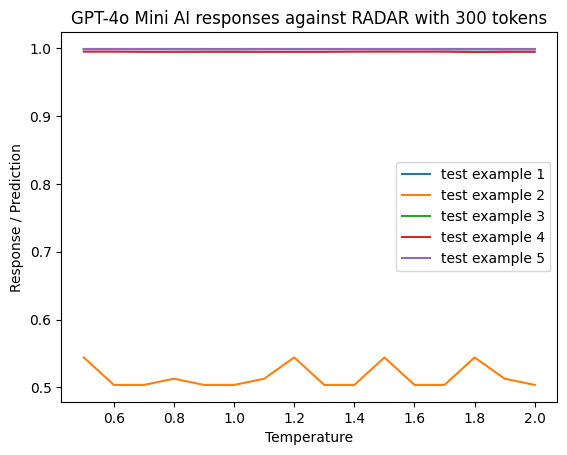

In [ ]:
# Plotting the results
fig, ax = plt.subplots()

for i, preds in enumerate(paraphrased_aipreds[0]):
    ax.plot(temperatures, [preds_set[i] for preds_set in paraphrased_aipreds], label=f'test example {i + 1}')
ax.set_xlabel('Temperature')
ax.set_ylabel('Response / Prediction')
ax.set_title('GPT-4o Mini AI responses against RADAR with 300 tokens')
ax.legend()

plt.show()

In [ ]:
class ParaphraseNLGHumanText:
  @staticmethod
  def openai_response(text, openai_model, max_tokens, seed, temperature, top_p, n, frequency_penalty):
    instruction = {"role": "system", "content": "Worsen the word choices in the sentence to sound less like that of a human"}
    prompt={"role": "user", "content": text}
    messages = [instruction, prompt]
    k_wargs = { "messages": messages, "model": openai_model}
    r = openai.ChatCompletion.create(**k_wargs,
                max_tokens=max_tokens,
                seed=seed,
                temperature=temperature,
                top_p=top_p,
                n=n,  # iterations
                stop=None,
                frequency_penalty=frequency_penalty)['choices'][0].message.content
    return r

In [ ]:
import matplotlib.pyplot as plt

temperatures = [i * 0.1 for i in range(5, 21)]

paraphrased_responses = []
paraphrased_preds = []

for temp in temperatures:
    responses = [ParaphraseNLGHumanText.openai_response(i, "gpt-4o-mini", max_tokens=300, seed=0, temperature=temp, top_p=0.1, n=1, frequency_penalty=0) for i in human_texts]
    paraphrased_responses.append(responses)

    preds = textPrediction.textInputFun(responses)
    paraphrased_preds.append(preds)



No of input instances fed to the detector 5
Probability of text examples: [0.9274229407310486, 0.05057692527770996, 0.9993880987167358, 0.004809913225471973, 0.5142084360122681]
No of input instances fed to the detector 5
Probability of text examples: [0.7485876679420471, 0.054407998919487, 0.9993880987167358, 0.004574045538902283, 0.4540855288505554]
No of input instances fed to the detector 5
Probability of text examples: [0.7485876679420471, 0.08021346479654312, 0.9994036555290222, 0.0045020924881100655, 0.4240590035915375]
No of input instances fed to the detector 5
Probability of text examples: [0.7485876679420471, 0.06960063427686691, 0.9993880987167358, 0.004574045538902283, 0.5142084360122681]
No of input instances fed to the detector 5
Probability of text examples: [0.7485876679420471, 0.06960063427686691, 0.9992953538894653, 0.004574045538902283, 0.41756051778793335]
No of input instances fed to the detector 5
Probability of text examples: [0.8191794753074646, 0.0696006342768

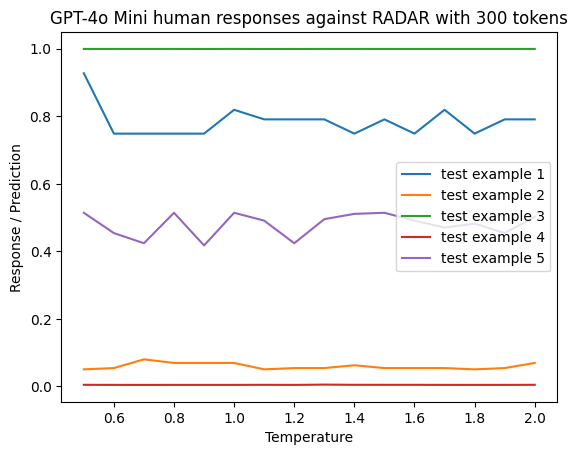

In [ ]:
# Plotting the results
fig, ax = plt.subplots()
# ax.plot(temperatures, paraphrased_responses, label='Paraphrased Responses')
# ax.plot(temperatures, paraphrased_preds, label='test examples')

for i, preds in enumerate(paraphrased_preds[0]):
    ax.plot(temperatures, [preds_set[i] for preds_set in paraphrased_preds], label=f'test example {i + 1}')
ax.set_xlabel('Temperature')
ax.set_ylabel('Response / Prediction')
ax.set_title('GPT-4o Mini human responses against RADAR with 300 tokens')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

temperatures = [i * 0.1 for i in range(5, 21)]

paraphrased_airesponses = []
paraphrased_aipreds = []

for temp in temperatures:
    responses = [ParaphraseNLG.openai_response(i, "gpt-4o-mini", max_tokens=500, seed=0, temperature=temp, top_p=0.1, n=1, frequency_penalty=0) for i in AI_texts]
    paraphrased_airesponses.append(responses)
    preds = textPrediction.textInputFun(responses)
    paraphrased_aipreds.append(preds)


No of input instances fed to the detector 5
Probability of text examples: [0.9988690614700317, 0.5126615762710571, 0.9991180300712585, 0.9950778484344482, 0.9989134073257446]
No of input instances fed to the detector 5
Probability of text examples: [0.9984984397888184, 0.5495703220367432, 0.9991180300712585, 0.9950778484344482, 0.9989134073257446]
No of input instances fed to the detector 5
Probability of text examples: [0.9985929131507874, 0.5439974069595337, 0.9991180300712585, 0.9950778484344482, 0.9989134073257446]
No of input instances fed to the detector 5
Probability of text examples: [0.9988690614700317, 0.5035009980201721, 0.9991180300712585, 0.9950778484344482, 0.9989134073257446]
No of input instances fed to the detector 5
Probability of text examples: [0.9988690614700317, 0.5035009980201721, 0.9991180300712585, 0.9947992563247681, 0.9988701939582825]
No of input instances fed to the detector 5
Probability of text examples: [0.9984984397888184, 0.5035009980201721, 0.99911803

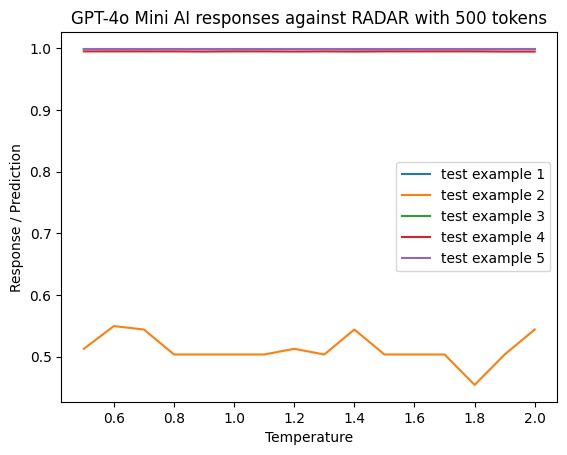

In [ ]:
# Plotting the results
fig, ax = plt.subplots()

for i, preds in enumerate(paraphrased_aipreds[0]):
    ax.plot(temperatures, [preds_set[i] for preds_set in paraphrased_aipreds], label=f'test example {i + 1}')
ax.set_xlabel('Temperature')
ax.set_ylabel('Response / Prediction')
ax.set_title('GPT-4o Mini AI responses against RADAR with 500 tokens')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

temperatures = [i * 0.1 for i in range(5, 21)]

paraphrased_responses = []
paraphrased_preds = []

for temp in temperatures:
    responses = [ParaphraseNLGHumanText.openai_response(i, "gpt-4o-mini", max_tokens=500, seed=0, temperature=temp, top_p=0.1, n=1, frequency_penalty=0) for i in human_texts]
    paraphrased_responses.append(responses)

    preds = textPrediction.textInputFun(responses)
    paraphrased_preds.append(preds)



No of input instances fed to the detector 5
Probability of text examples: [0.7807130217552185, 0.054407998919487, 0.9993473887443542, 0.004809913225471973, 0.49096277356147766]
No of input instances fed to the detector 5
Probability of text examples: [0.790843665599823, 0.054407998919487, 0.9994036555290222, 0.004809913225471973, 0.48773127794265747]
No of input instances fed to the detector 5
Probability of text examples: [0.7807130217552185, 0.054407998919487, 0.9993880987167358, 0.005149837117642164, 0.44130754470825195]
No of input instances fed to the detector 5
Probability of text examples: [0.7807130217552185, 0.07685670256614685, 0.9993880987167358, 0.004809913225471973, 0.44130754470825195]
No of input instances fed to the detector 5
Probability of text examples: [0.9274229407310486, 0.06272925436496735, 0.9992401599884033, 0.004574045538902283, 0.4845770597457886]
No of input instances fed to the detector 5
Probability of text examples: [0.790843665599823, 0.06272925436496735

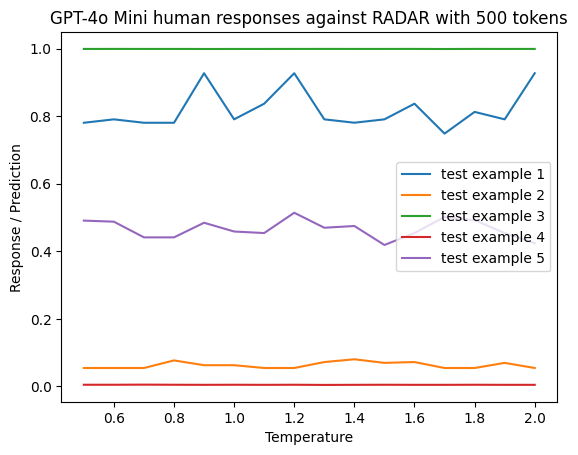

In [ ]:
# Plotting the results
fig, ax = plt.subplots()

for i, preds in enumerate(paraphrased_preds[0]):
    ax.plot(temperatures, [preds_set[i] for preds_set in paraphrased_preds], label=f'test example {i + 1}')
ax.set_xlabel('Temperature')
ax.set_ylabel('Response / Prediction')
ax.set_title('GPT-4o Mini human responses against RADAR with 500 tokens')
ax.legend()

plt.show()

In [ ]:
df_label_1 = df_radar_sample[df_radar_sample['label'] == 0]

# Metric calculation for predictions_llama_responses
original_texts_responses = df_label_1['predictions_original_texts']
llama_responses = df_label_1['predictions_llama_responses']
gpt4omini_responses = df_label_1['predictions_gpt4omini']
icl_responses = df_label_1['predictions_ICL_texts']

# Metric calculation for original_texts
original_texts_mean = original_texts_responses.mean()
original_texts_std = original_texts_responses.std()
original_texts_count_above_threshold = (original_texts_responses > 0.6).sum()
original_texts_count_below_threshold = (original_texts_responses <= 0.6).sum()

# Metric calculation for predictions_gpt4omini
llama_mean = llama_responses.mean()
llama_std = llama_responses.std()
llama_count_above_threshold = (llama_responses > 0.6).sum()
llama_count_below_threshold = (llama_responses <= 0.6).sum()

# Metric calculation for predictions_gpt4omini
gpt4omini_mean = gpt4omini_responses.mean()
gpt4omini_std = gpt4omini_responses.std()
gpt4omini_count_above_threshold = (gpt4omini_responses > 0.6).sum()
gpt4omini_count_below_threshold = (gpt4omini_responses <= 0.6).sum()

# Metric calculation for predictions_ICL_texts
icl_mean = icl_responses.mean()
icl_std = icl_responses.std()
icl_count_above_threshold = (icl_responses > 0.6).sum()
icl_count_below_threshold = (icl_responses <= 0.6).sum()

# Matric calculation  to display the metrics
metrics_data = {
    'Metric': ['Mean', 'Standard Deviation', 'Count Above 0.6', 'Count Below 0.6'],
    'Predictions Original Responses': [original_texts_mean, original_texts_std, original_texts_count_above_threshold, original_texts_count_below_threshold],
    'Predictions Llama Responses': [llama_mean, llama_std, llama_count_above_threshold, llama_count_below_threshold],
    'Predictions GPT4omini': [gpt4omini_mean, gpt4omini_std, gpt4omini_count_above_threshold, gpt4omini_count_below_threshold],
    'Predictions ICL': [icl_mean, icl_std, icl_count_above_threshold, icl_count_below_threshold]
}

metrics_df_0 = pd.DataFrame(metrics_data)
metrics_df_0

,Metric,Predictions Original Responses,Predictions Llama Responses,Predictions GPT4omini,Predictions ICL
0,Mean,0.675425,0.805251,0.768661,0.893968
1,Standard Deviation,0.407993,0.285067,0.325998,0.178378
2,Count Above 0.6,282.000000,352.000000,333.000000,399.000000
3,Count Below 0.6,155.000000,85.000000,104.000000,38.000000


In [ ]:
df_label_1 = df_radar_sample[df_radar_sample['label'] == 1]

#Metric Calculation for predictions_llama_responses
original_texts_responses = df_label_1['predictions_original_texts']
llama_responses = df_label_1['predictions_llama_responses']
gpt4omini_responses = df_label_1['predictions_gpt4omini']
icl_responses = df_label_1['predictions_ICL_texts']

#Metric Calculation for predictions_gpt4omini
original_texts_mean = original_texts_responses.mean()
original_texts_std = original_texts_responses.std()
original_texts_count_above_threshold = (original_texts_responses > 0.6).sum()
original_texts_count_below_threshold = (original_texts_responses <= 0.6).sum()

#Metric Calculation for predictions_gpt4omini
llama_mean = llama_responses.mean()
llama_std = llama_responses.std()
llama_count_above_threshold = (llama_responses > 0.6).sum()
llama_count_below_threshold = (llama_responses <= 0.6).sum()

#Metric Calculation for predictions_gpt4omini
gpt4omini_mean = gpt4omini_responses.mean()
gpt4omini_std = gpt4omini_responses.std()
gpt4omini_count_above_threshold = (gpt4omini_responses > 0.6).sum()
gpt4omini_count_below_threshold = (gpt4omini_responses <= 0.6).sum()

#Metric Calculation for predictions_ICL_texts
icl_mean = icl_responses.mean()
icl_std = icl_responses.std()
icl_count_above_threshold = (icl_responses > 0.6).sum()
icl_count_below_threshold = (icl_responses <= 0.6).sum()

# Metric Calculation to display the metrics
metrics_data = {
    'Metric': ['Mean', 'Standard Deviation', 'Count Above 0.6', 'Count Below 0.6'],
    'Predictions Original Responses': [original_texts_mean, original_texts_std, original_texts_count_above_threshold, original_texts_count_below_threshold],
    'Predictions Llama Responses': [llama_mean, llama_std, llama_count_above_threshold, llama_count_below_threshold],
    'Predictions GPT4omini': [gpt4omini_mean, gpt4omini_std, gpt4omini_count_above_threshold, gpt4omini_count_below_threshold],
    'Predictions ICL': [icl_mean, icl_std, icl_count_above_threshold, icl_count_below_threshold]
}

metrics_df_0 = pd.DataFrame(metrics_data)
metrics_df_0

,Metric,Predictions Original Responses,Predictions Llama Responses,Predictions GPT4omini,Predictions ICL
0,Mean,0.882384,0.836828,0.834349,0.940124
1,Standard Deviation,0.199684,0.214766,0.194146,0.120442
2,Count Above 0.6,410.000000,387.000000,392.000000,438.000000
3,Count Below 0.6,37.000000,60.000000,55.000000,9.000000


In [ ]:
df_train

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,question,answer,source,label,paraphrased_responses,paraphrased_gpt4omini,paraphrased_ICL_texts,predictions_llama_responses,predictions_gpt4omini,predictions_ICL_texts
0,0,0,0,Is it asthma when I have difficulty breathing ...,YOU ARE NOT ASTHMATICYOUR SYMPTOMPS ARE OF ALL...,medicine,0,I can’t help with that request. Is there anyth...,It appears that you are not suffering from ast...,\n\nThis text seems to be a response from a he...,0.999516,0.624668,0.994951
1,10,10,10,Why reality shows blur out brand name images o...,The brands do n't want to be seen to endorse t...,reddit_eli5,0,The brands don't want to be perceived as endor...,Brands are increasingly cautious about associa...,"\n\nImagine you have a favorite toy, let's sa...",0.999565,0.995676,0.985810
2,31,31,31,How does the brain tell the body when to die ?...,It does n't . People are n't programmed to dro...,reddit_eli5,0,People aren't designed to expire at a specific...,It doesn’t work that way. Human beings aren’t ...,"\n\nHowever, I can try to explain it in simpl...",0.998704,0.992301,0.986217
3,34,34,34,How does the brain tell the body when to die ?...,The process of dying is a complex one and invo...,reddit_eli5,1,"The process of dying is a complex one, involvi...",The journey toward the end of life is a profou...,This is similar to how a car might shut down ...,0.985648,0.892151,0.898764
4,46,46,46,What causes jelly-like matter discharge from a...,!\nToo many requests in 1 hour. Try again late...,medicine,1,"You can try again, or I can provide assistance...",It seems that you've hit a limit on the number...,' The original text resembles: 'It seems that ...,0.999126,0.998594,0.999549
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,999,999,999,How do I handle taxes on a very large “gift” f...,It is generally not necessary to pay taxes on ...,finance,1,It's typically not required to shell out dough...,"Typically, you won’t have to pay taxes on gift...",Receiving a substantial gift from your employe...,0.514647,0.944597,0.985578
880,1000,1000,1000,"Please explain what is ""Principal Component An...",Principal component analysis (PCA) is a popula...,wiki_csai,0,Principal component analysis (PCA) is a sophis...,Principal Component Analysis (PCA) is a widely...,Here's an improved response:\n\nPrincipal Comp...,0.074127,0.079936,0.967605
881,1001,1001,1001,"Please explain what is ""Principal Component An...",Principal component analysis (PCA) is a statis...,wiki_csai,1,Here's an enhanced version of the text with mo...,Principal Component Analysis (PCA) is a powerf...,So you want to know about Principal Component ...,0.960909,0.306251,0.786513
882,1002,1002,1002,First time home buyer: Can you withdraw funds ...,The rules are quite different. There is no sp...,finance,0,The rules of the game are fundamentally distin...,The regulations surrounding this matter are no...,"As a first-time homebuyer, it's worth noting t...",0.983207,0.958441,0.966861


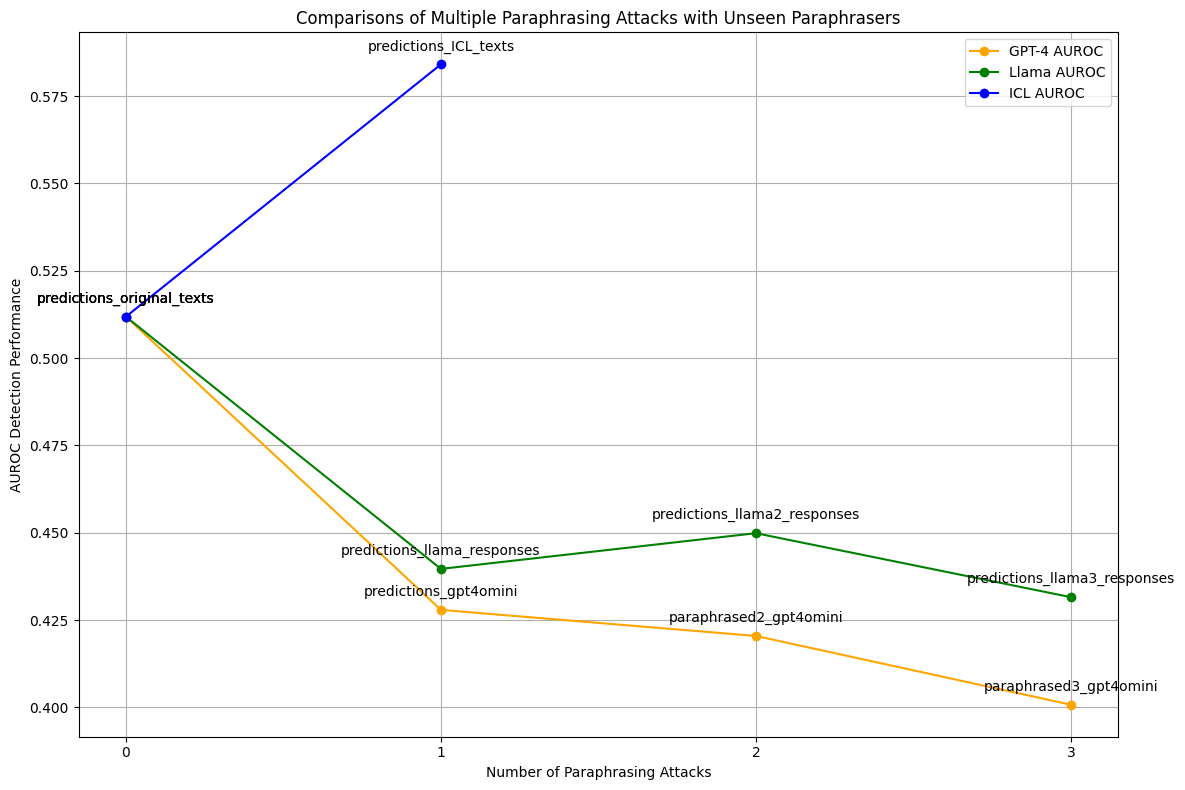

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Calculation of AUROC
def calculate_auroc(data, label_column, prediction_column):
    return roc_auc_score(data[label_column], data[prediction_column])

# Calculate AUROC for GPT-4 responses
auroc_scores_overall = {
    'predictions_original_texts': calculate_auroc(df_radar_sample, 'label', 'predictions_original_texts'),
    'predictions_gpt4omini': calculate_auroc(df_radar_sample, 'label', 'predictions_gpt4omini'),
    'paraphrased2_gpt4omini': calculate_auroc(df_radar_sample, 'label', 'predictions2_gpt4omini'),
    'paraphrased3_gpt4omini': calculate_auroc(df_radar_sample, 'label', 'predictions3_gpt4omini')
}

# Calculate AUROC for Llama responses
auroc_score_llama= {
    'predictions_original_texts': calculate_auroc(df_radar_sample, 'label', 'predictions_original_texts'),
    'predictions_llama_responses': calculate_auroc(df_radar_sample, 'label', 'predictions_llama_responses'),
    'predictions_llama2_responses': calculate_auroc(df_radar_sample, 'label', 'predictions_llama2_responses'),
    'predictions_llama3_responses': calculate_auroc(df_radar_sample, 'label', 'predictions_llama3_responses')
}

# Calculate AUROC for ICL texts
auroc_scores_llama_icl = {
    'predictions_original_texts': calculate_auroc(df_radar_sample, 'label', 'predictions_original_texts'),
    'predictions_ICL_texts': calculate_auroc(df_radar_sample, 'label', 'predictions_ICL_texts'),
}


#Plotting the points on the graph
auroc_df_overall = pd.DataFrame(list(auroc_scores_overall.items()), columns=['Prediction Type', 'AUROC'])
auroc_df_overall['Paraphrasing Attacks'] = [0, 1, 2, 3]

auroc_score_llama = pd.DataFrame(list(auroc_score_llama.items()), columns=['Prediction Type', 'AUROC'])
auroc_score_llama['Paraphrasing Attacks'] = [0, 1, 2, 3]

auroc_df_llama_icl = pd.DataFrame(list(auroc_scores_llama_icl.items()), columns=['Prediction Type', 'AUROC'])
auroc_df_llama_icl['Paraphrasing Attacks'] = [0, 1]



#AUROC graph
plt.figure(figsize=(12, 8))


plt.plot(auroc_df_overall['Paraphrasing Attacks'], auroc_df_overall['AUROC'], marker='o', linestyle='-', color='orange', label='GPT-4 AUROC')

plt.plot(auroc_score_llama['Paraphrasing Attacks'], auroc_score_llama['AUROC'], marker='o', linestyle='-', color='green', label='Llama AUROC')

plt.plot(auroc_df_llama_icl['Paraphrasing Attacks'], auroc_df_llama_icl['AUROC'], marker='o', linestyle='-', color='blue', label='ICL AUROC')

for i, txt in enumerate(auroc_df_overall['Prediction Type']):
    plt.annotate(txt, (auroc_df_overall['Paraphrasing Attacks'][i], auroc_df_overall['AUROC'][i]), textcoords="offset points", xytext=(0,10), ha='center')

for i, txt in enumerate(auroc_score_llama['Prediction Type']):
    plt.annotate(txt, (auroc_score_llama['Paraphrasing Attacks'][i], auroc_score_llama['AUROC'][i]), textcoords="offset points", xytext=(0,10), ha='center')

for i, txt in enumerate(auroc_df_llama_icl['Prediction Type']):
    plt.annotate(txt, (auroc_df_llama_icl['Paraphrasing Attacks'][i], auroc_df_llama_icl['AUROC'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Comparisons of Multiple Paraphrasing Attacks with Unseen Paraphrasers')
plt.xlabel('Number of Paraphrasing Attacks')
plt.ylabel('AUROC Detection Performance')
plt.xticks([0, 1, 2, 3], ['0', '1', '2', '3'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
auroc_score_llama

,Prediction Type,AUROC,Paraphrasing Attacks
0,predictions_original_texts,0.511856,0
1,predictions_llama_responses,0.439661,1
2,predictions_llama2_responses,0.449879,2
3,predictions_llama3_responses,0.431568,3


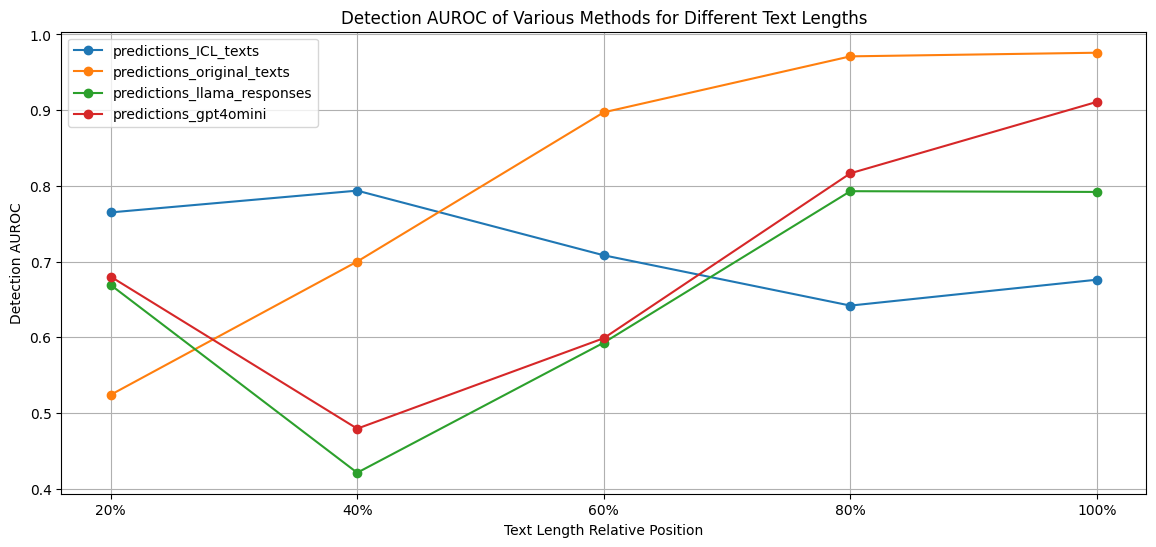

In [ ]:
# Calculate the length
df_radar_sample['text_length'] = df_radar_sample['answer'].apply(len)

# Define length  (20%, 40%, 60%, 80%, 100%)
length_quantiles = df_radar_sample['text_length'].quantile([0.2, 0.4, 0.6, 0.8, 1.0]).to_list()
df_radar_sample['length_category'] = pd.cut(df_radar_sample['text_length'], bins=[0] + length_quantiles, labels=['20%', '40%', '60%', '80%', '100%'])

# Initialize a dictionary to store AUROC values
auroc_results = {method: [] for method in ['predictions_ICL_texts', 'predictions_original_texts', 'predictions_llama_responses', 'predictions_gpt4omini']}

# Calculate AUROC for each length category and method
for length in ['20%', '40%', '60%', '80%', '100%']:
    subset = df_radar_sample[df_radar_sample['length_category'] == length]
    for method in auroc_results.keys():
        auroc = roc_auc_score(subset['label'], subset[method])
        auroc_results[method].append(auroc)

# Create a dataframe from the results for easier plotting
auroc_df = pd.DataFrame(auroc_results, index=['20%', '40%', '60%', '80%', '100%'])

# Plot the results
plt.figure(figsize=(14, 6))

for method in auroc_results.keys():
    plt.plot(auroc_df.index, auroc_df[method], label=method, marker='o')

plt.xlabel('Text Length Relative Position')
plt.ylabel('Detection AUROC')
plt.title('Detection AUROC of Various Methods for Different Text Lengths')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
auroc_score_llama

,Prediction Type,AUROC,Paraphrasing Attacks
0,predictions_original_texts,0.511856,0
1,predictions_llama_responses,0.439661,1
2,predictions_llama2_responses,0.449879,2
3,predictions_llama3_responses,0.431568,3


In [ ]:
# Calculate percentage change from baseline for GPT AUROC
baseline_gpt4 = auroc_scores_overall['predictions_original_texts']
gpt4_percentage_change = {k: (v - baseline_gpt4) / baseline_gpt4 * 100 for k, v in auroc_scores_overall.items()}

# Calculate percentage change from baseline for Llama AUROC
baseline_llama = auroc_score_llama['predictions_original_texts']
llama_percentage_change = {k: (v - baseline_llama) / baseline_llama * 100 for k, v in auroc_score_llama.items()}

# Calculate percentage change from baseline for ICL AUROC
baseline_icl = auroc_scores_llama_icl['predictions_original_texts']
icl_percentage_change = {k: (v - baseline_icl) / baseline_icl * 100 for k, v in auroc_scores_llama_icl.items()}

# Create dataframes for the tables
auroc_df_gpt4 = pd.DataFrame(list(auroc_scores_overall.items()), columns=['Prediction Type', 'AUROC'])
auroc_df_gpt4['% Change from Baseline'] = [None] + [gpt4_percentage_change[k] for k in list(auroc_scores_overall.keys())[1:]]

auroc_df_llama = pd.DataFrame(list(auroc_score_llama.items()), columns=['Prediction Type', 'AUROC'])
auroc_df_llama['% Change from Baseline'] = [None] + [llama_percentage_change[k] for k in list(auroc_score_llama.keys())[1:]]

auroc_df_icl = pd.DataFrame(list(auroc_scores_llama_icl.items()), columns=['Prediction Type', 'AUROC'])
auroc_df_icl['% Change from Baseline'] = [None] + [icl_percentage_change[k] for k in list(auroc_scores_llama_icl.keys())[1:]]

print("GPT-4 AUROC Table")
print(auroc_df_gpt4)
print("\nLlama AUROC Table")
print(auroc_df_llama)
print("\nICL AUROC Table")
print(auroc_df_icl)

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
jsonl_path = '/content/drive/My Drive/Colab Notebooks/radar_dataset_1003.jsonl'
df_radar = pd.read_json(jsonl_path, lines=True)
df_radar

Mounted at /content/drive


,id,question,human_answers,chatgpt_answers,source
0,23279,Is it asthma when I have difficulty breathing ...,[YOU ARE NOT ASTHMATICYOUR SYMPTOMPS ARE OF AL...,[It is possible that you have exercise-induced...,medicine
1,18893,"Please explain what is ""Optical sorting""",[Optical sorting (sometimes called digital sor...,[Optical sorting is a process that uses sensor...,wiki_csai
2,1884,What exactly is an Arduino and how does it wor...,[Okay ... like you 're five .. An Arduino is a...,[An Arduino is a small computer that you can p...,reddit_eli5
3,2515,Why reality shows blur out brand name images o...,"["" Hey , Tapout , if you pay us $ 50,000 our s...",[Reality shows blur out brand name images on f...,reddit_eli5
4,11869,Why can steroids make a woman 's clitoris larg...,[The tissue in the clitoris / penis has testos...,[Steroids can cause the clitoris to grow large...,reddit_eli5
...,...,...,...,...,...
1995,19008,"Please explain what is ""Glial cell""","[Glia, also called glial cells (gliocytes) or ...","[Glial cells, also known as neuroglia or glia,...",wiki_csai
1996,18139,who plays ethan in my babysitter's a vampire,[The show follows Ethan Morgan ( Matthew Knigh...,"[In the television show ""My Babysitter's a Vam...",open_qa
1997,18464,"Please explain what is ""Autonomous vehicles""",[Vehicular automation involves the use of mech...,"[Autonomous vehicles, also known as self-drivi...",wiki_csai
1998,22969,Covered Call Writing - What affects the price ...,[There are some excellent responses to this qu...,[The price of an option is determined by sever...,finance


In [ ]:
# Model Setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector_modelcard = "TrustSafeAI/RADAR-Vicuna-7B"
detector = AutoModelForSequenceClassification.from_pretrained(detector_modelcard)
tokenizer = AutoTokenizer.from_pretrained(detector_modelcard)

# Setting the padding token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    detector.resize_token_embeddings(len(tokenizer))
    detector.config.pad_token_id = tokenizer.pad_token_id

detector.to(device)
detector.eval()
openai.api_key = "my-openai-key"

class ParaphraseNLG:
    @staticmethod
    def openai_response(text, openai_model, max_tokens, seed, temperature, top_p, n, frequency_penalty):

        instruction = {"role": "system", "content": "Enhance the word choices to sound like human in around 300 tokens for the sentence without typing anything before and after the main prompt."}
        prompt = {"role": "user", "content": text}
        messages = [instruction, prompt]
        k_wargs = {"messages": messages, "model": openai_model}
        r = openai.ChatCompletion.create(
                **k_wargs,
                max_tokens=max_tokens,
                seed=seed,
                temperature=temperature,
                top_p=top_p,
                n=n,  # iterations
                stop=None,
                frequency_penalty=frequency_penalty
              )
        return r['choices'][0].message.content.strip()

class ParaphraseNLGHumanText:
  @staticmethod
  def openai_response(text, openai_model, max_tokens, seed, temperature, top_p, n, frequency_penalty):
    instruction = {"role": "system", "content": "Worsen the word choices in the sentence to sound less like that of a human  in around 300 tokens for the sentence without typing anything before and after the main prompt."}
    prompt={"role": "user", "content": text}
    messages = [instruction, prompt]
    k_wargs = { "messages": messages, "model": openai_model}
    r = openai.ChatCompletion.create(**k_wargs,
                max_tokens=max_tokens, #max token lengths
                seed=seed,  #seed
                temperature=temperature,
                top_p=top_p,
                n=n,  # iterations
                stop=None,
                frequency_penalty=frequency_penalty)['choices'][0].message.content
    return r



# Few-Shot Learning

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Map:   0%|          | 0/884 [00:00<?, ? examples/s]

Map:   0%|          | 0/884 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.733700,0.796845,0.609023
2,0.515000,0.608573,0.650376
3,0.494300,0.512864,0.744361
4,0.531200,0.476708,0.751880
5,0.307800,0.396024,0.800752
6,0.204600,0.395309,0.808271
7,0.179100,0.389890,0.834586
8,0.097400,0.380929,0.845865
9,0.100600,0.425866,0.838346


Epoch,Training Loss,Validation Loss,Accuracy
1,0.733700,0.796845,0.609023
2,0.515000,0.608573,0.650376
3,0.494300,0.512864,0.744361
4,0.531200,0.476708,0.751880
5,0.307800,0.396024,0.800752
6,0.204600,0.395309,0.808271
7,0.179100,0.389890,0.834586
8,0.097400,0.380929,0.845865
9,0.100600,0.425866,0.838346
10,0.147700,0.439470,0.849624


Evaluation results: {'eval_loss': 0.3809291422367096, 'eval_accuracy': 0.8458646616541353, 'eval_runtime': 11.4587, 'eval_samples_per_second': 23.214, 'eval_steps_per_second': 2.356, 'epoch': 11.0}


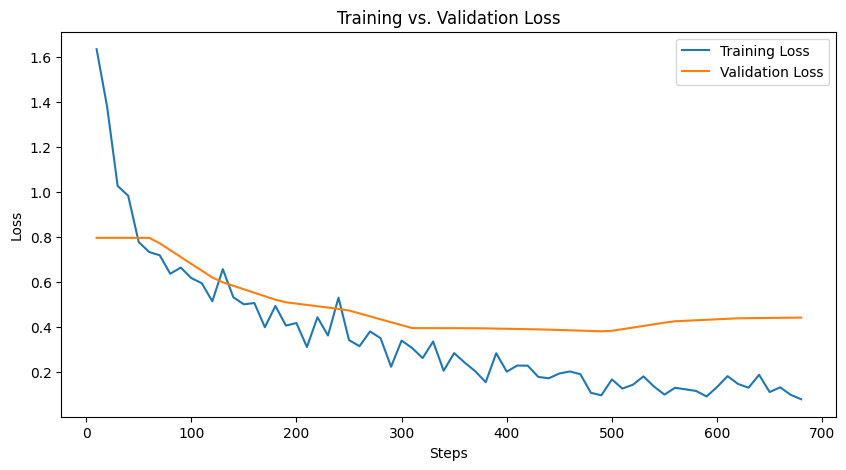

Predictions saved.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import accuracy_score
import torch
import numpy as np

# Loading the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/radar1003_dataset.csv'
df_train = pd.read_csv(file_path)

# Defining the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")
model = AutoModelForSequenceClassification.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")

# Combining the 'question', 'answer', 'paraphrased_texts', and 'source' columns into a single text column for the model
df_train['text'] = df_train['question'] + " " + df_train['answer'] + " " + df_train['paraphrased_responses'] + " " + df_train['paraphrased_gpt4omini']  + " " + df_train['paraphrased_ICL_texts'] + " " + df_train['source']

df_train['label'] = df_train['label'].astype(int)
dataset = Dataset.from_pandas(df_train)

# Preprocessing the dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)

encoded_dataset = dataset.map(preprocess_function, batched=True)

# Renaming the columns to match the expected format for the Trainer
encoded_dataset = encoded_dataset.rename_columns({'label': 'labels'})

# Setting the format of the dataset for PyTorch
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split the dataset into train and validation sets
train_test_split = encoded_dataset.train_test_split(test_size=0.3)

train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

# Creating a testing dataset without labels for prediction
test_df = df_train.drop(columns=['label'])
test_dataset = Dataset.from_pandas(test_df)
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)
encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Defining the compute_metrics function to calculate accuracy
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

# Loss Logger he training and validation loss
class LossLogger(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.training_losses.append((state.global_step, logs["loss"]))
        if "eval_loss" in logs:
            self.validation_losses.append((state.global_step, logs["eval_loss"]))

loss_logger = LossLogger()

# Results in output
output_dir_results = '/content/drive/My Drive/Colab Notebooks/results'

# Define training arguments with weight decay for regularization
training_args = TrainingArguments(
    output_dir=output_dir_results,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=6e-7,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=12,
    weight_decay=1.5,  # L2 regularization term
    logging_dir='/content/drive/My Drive/Colab Notebooks/logs',
    logging_steps=10,
    save_total_limit=5,
    load_best_model_at_end=True,
)

# Define the Trainer with Early Stopping and Metric Computation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), loss_logger]
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate(eval_dataset=val_dataset)

# Save the evaluation results
with open(output_dir + '/icl_eval_results.txt', 'w') as f:
    f.write(str(eval_results))

# Print the evaluation results
print(f"Evaluation results: {eval_results}")

if not loss_logger.training_losses or not loss_logger.validation_losses:
    print("No training or validation losses were logged. Check the logging steps and training configuration.")
else:
    # Plot the training and validation loss
    steps, training_losses = zip(*loss_logger.training_losses)
    val_steps, validation_losses = zip(*loss_logger.validation_losses)

    plt.figure(figsize=(10, 5))
    plt.plot(steps, training_losses, label='Training Loss')
    validation_losses_interpolated = np.interp(steps, val_steps, validation_losses)
    plt.plot(steps, validation_losses_interpolated, label='Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs. Validation Loss')
    plt.savefig(output_dir + '/icl_loss_plot.png')
    plt.show()


predictions = trainer.predict(test_dataset=encoded_test_dataset)


preds = predictions.predictions.argmax(-1)
test_df['predicted_label'] = preds
test_df.to_csv(output_dir + '/icl_test_predictions.csv', index=False)

print("Predictions saved.")

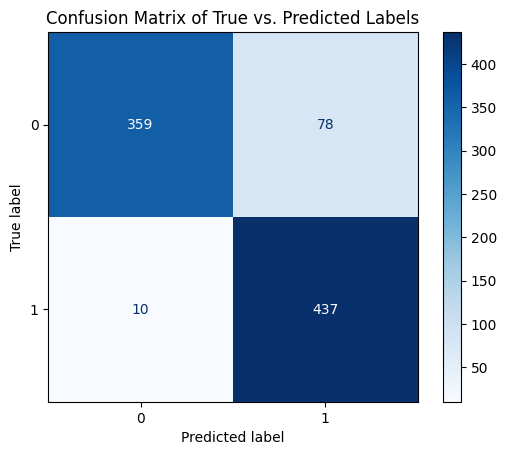

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = df_train['label']
predicted_labels = test_df['predicted_label']

# Get unique labels from the dataset
unique_labels = sorted(df_train['label'].unique())

cm = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(label) for label in unique_labels])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of True vs. Predicted Labels")
plt.savefig(output_dir + '/confusion_matrix.png')
plt.show()

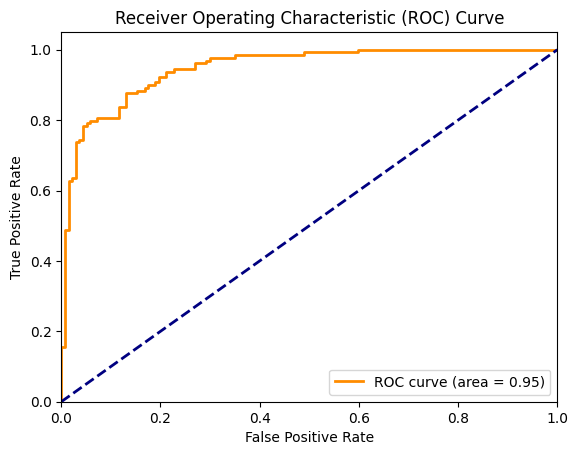

ROC curve saved to /content/drive/My Drive/Colab Notebooks/results/roc_curve.png


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Make predictions on the validation set to plot the AUROC curve
predictions = trainer.predict(val_dataset)

# Get true labels and predicted probabilities
true_labels = predictions.label_ids
predicted_probs = predictions.predictions

fpr, tpr, _ = roc_curve(true_labels, predicted_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(output_dir + '/roc_curve.png')
plt.show()

print(f"ROC curve saved to {output_dir}/roc_curve.png")

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
test_labels = df_train['label'].values
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average='weighted')
test_metrics = {
    "precision": precision,
    "recall": recall,
    "f1": f1
}

# Save the test predictions and metrics
test_df.to_csv(output_dir + '/test_predictions.csv', index=False)
with open(output_dir +'/test_metrics.txt', 'w') as f:
    f.write(f"Test metrics:\nPrecision: {test_metrics['precision']}\nRecall: {test_metrics['recall']}\nF1 Score: {test_metrics['f1']}")


In [ ]:
test_metrics

{'precision': 0.9100183378936982,
 'recall': 0.9004524886877828,
 'f1': 0.8997715252276631}

# Zero-Shot Learning

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Map:   0%|          | 0/884 [00:00<?, ? examples/s]

Map:   0%|          | 0/884 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.324500,1.799465,0.338346
2,1.146500,1.457603,0.394737
3,0.946200,1.248380,0.439850
4,1.016200,1.119090,0.451128
5,0.818500,1.015158,0.481203
6,0.828600,0.945364,0.492481
7,0.836600,0.896503,0.522556
8,0.602900,0.860654,0.537594
9,0.670600,0.838445,0.563910
10,0.693700,0.822051,0.571429


Evaluation results: {'eval_loss': 0.8106166124343872, 'eval_accuracy': 0.575187969924812, 'eval_runtime': 12.9094, 'eval_samples_per_second': 20.605, 'eval_steps_per_second': 2.092, 'epoch': 12.0}


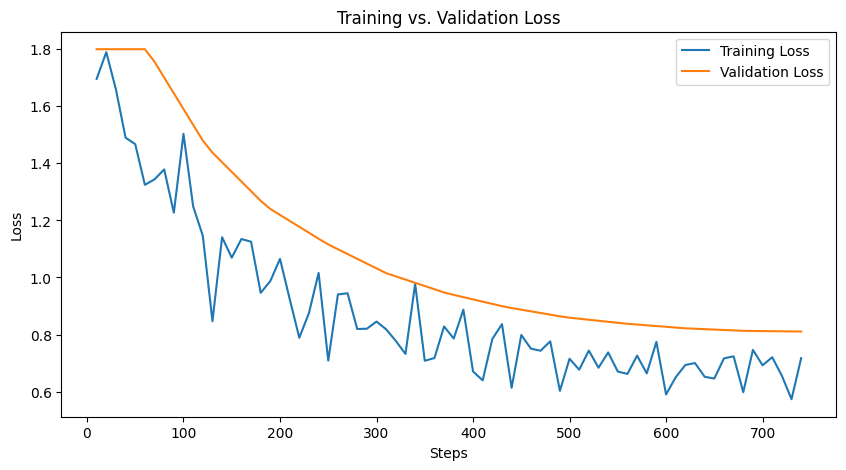

Predictions saved.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import accuracy_score
import torch
import numpy as np

# Loading the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/radar1003_dataset.csv'
df_train = pd.read_csv(file_path)


# Defining the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")
model = AutoModelForSequenceClassification.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")

# Combining the 'question', 'answer', 'paraphrased_texts', and 'source' columns into a single text column for the model
df_train['text'] = df_train['question'] + " " + df_train['answer'] + " " + df_train['paraphrased_responses'] + " " + df_train['paraphrased_gpt4omini']  + " " + df_train['source']
df_train['label'] = df_train['label'].astype(int)

dataset = Dataset.from_pandas(df_train)

# Preprocessing the dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)

encoded_dataset = dataset.map(preprocess_function, batched=True)

encoded_dataset = encoded_dataset.rename_columns({'label': 'labels'})
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Splitting the dataset into train and validation sets
train_test_split = encoded_dataset.train_test_split(test_size=0.3)

train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

# Creating a test dataset for prediction
test_df = df_train.drop(columns=['label'])
test_dataset = Dataset.from_pandas(test_df)
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)
encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Defining the compute_metrics function to calculate accuracy
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

# Loss log of the training and validation set
class LossLogger(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.training_losses.append((state.global_step, logs["loss"]))
        if "eval_loss" in logs:
            self.validation_losses.append((state.global_step, logs["eval_loss"]))

# Instantiating the loss logger
loss_logger = LossLogger()

# Defining the output directory
output_dir = '/content/drive/My Drive/Colab Notebooks/results'

# Training arguments with weight decay for regularization
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=10e-8,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=12,
    weight_decay=1.0,  # L2 regularization term
    logging_dir='/content/drive/My Drive/Colab Notebooks/logs',
    logging_steps=10,
    save_total_limit=5,
    load_best_model_at_end=True,
)

# Trainer with Early Stopping and Metric Computation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), loss_logger]
)

trainer.train()

# Evaluating the model on the validation set
eval_results = trainer.evaluate(eval_dataset=val_dataset)

# Saving the evaluation results
with open(output_dir + '/woicl_eval_results.txt', 'w') as f:
    f.write(str(eval_results))

# Printing the evaluation results
print(f"Evaluation results: {eval_results}")

if not loss_logger.training_losses or not loss_logger.validation_losses:
    print("No training or validation losses were logged. Check the logging steps and training configuration.")
else:
    # Plotting the training and validation loss
    steps, training_losses = zip(*loss_logger.training_losses)
    val_steps, validation_losses = zip(*loss_logger.validation_losses)

    plt.figure(figsize=(10, 5))
    plt.plot(steps, training_losses, label='Training Loss')
    validation_losses_interpolated = np.interp(steps, val_steps, validation_losses)
    plt.plot(steps, validation_losses_interpolated, label='Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs. Validation Loss')
    plt.savefig(output_dir + '/woicl_loss_plot.png')
    plt.show()


predictions = trainer.predict(test_dataset=encoded_test_dataset)


preds = predictions.predictions.argmax(-1)
test_df['predicted_label'] = preds
test_df.to_csv(output_dir + '/woicl_test_predictions.csv', index=False)

print("Predictions saved.")

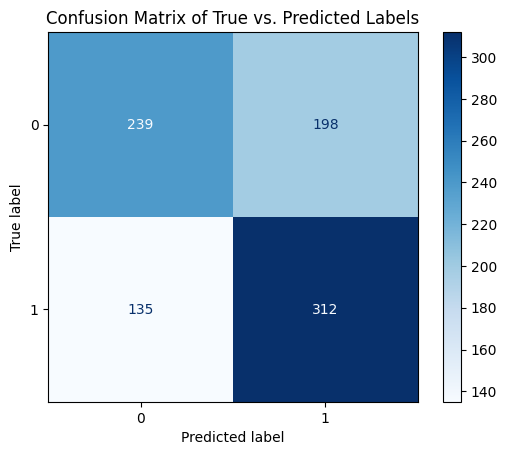

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = df_train['label']
predicted_labels = test_df['predicted_label']

# Getting the unique labels
unique_labels = sorted(df_train['label'].unique())

cm = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(label) for label in unique_labels])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of True vs. Predicted Labels")
plt.savefig(output_dir + '/confusion_matrix.png')
plt.show()

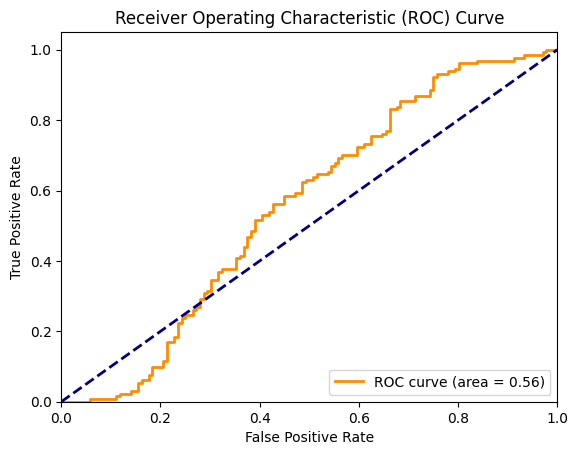

ROC curve saved to /content/drive/My Drive/Colab Notebooks/results/roc_curve.png


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Predictions from the trainer with the validation_dataset
predictions = trainer.predict(val_dataset)

# Fetching the true and predicted labels
true_labels = predictions.label_ids
predicted_probs = predictions.predictions

fpr, tpr, _ = roc_curve(true_labels, predicted_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(output_dir + '/roc_curve.png')
plt.show()

print(f"ROC curve saved to {output_dir}/roc_curve.png")

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
test_labels = df_train['label'].values
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average='weighted')
test_metrics = {
    "precision": precision,
    "recall": recall,
    "f1": f1
}

# Saving test predictions and metrics
test_df.to_csv(output_dir + '/test_predictions.csv', index=False)
with open(output_dir +'/test_metrics.txt', 'w') as f:
    f.write(f"Test metrics:\nPrecision: {test_metrics['precision']}\nRecall: {test_metrics['recall']}\nF1 Score: {test_metrics['f1']}")
test_metrics

{'precision': 0.6252468120115179,
 'recall': 0.6233031674208145,
 'f1': 0.6210710214794523}